In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import numpy as np

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.rdMolAlign import AlignMolConformers, AlignMol
from rdkit.Chem.Draw import rdMolDraw2D
from conf_ensemble_library import ConfEnsembleLibrary
from pdbbind_metadata_processor import PDBBindMetadataProcessor
from molconfviewer import MolConfViewer
from litschnet import LitSchNet
from molecule_featurizer import MoleculeFeaturizer
from torch_geometric.data import Batch
from ConfScorer import ConfAnalyzer

In [2]:
def get_model() :
    split = 'random'
    iteration = 0
    experiment_name = f'{split}_split_{iteration}'
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    model = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    return model

In [3]:
def save_2d_depiction(mol, path, atom_indices=False) :
    d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
    if atom_indices :
        d2d.drawOptions().addAtomIndices=True
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    d2d.WriteDrawingText(path) 

In [4]:
def get_most_similar_mol_in_train(test_mol, train_fps) :
    test_fp = AllChem.GetMorganFingerprint(test_mol, 3, useChirality=True)
    sims = []
    for train_fp in train_fps :
        dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
        sims.append(dice_sim)
    max_sim_idx = np.argmax(sims)
    print('Tanimoto similarity: ', np.max(sims))
    sim_smiles = train_smiles[max_sim_idx]

    sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
    return sim_ce.mol

In [5]:
split = 'random'
iteration = 0
with open(os.path.join('data/', f'ligand_{split}_splits', f'train_smiles_{split}_split_{iteration}.txt'), 'r') as f :
    train_smiles = f.readlines()
    train_smiles = [smiles.strip() for smiles in train_smiles]

In [6]:
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]
train_fps = [AllChem.GetMorganFingerprint(mol, 3, useChirality=True) for mol in train_mols]

In [7]:
mcv = MolConfViewer()
mf = MoleculeFeaturizer()
ca = ConfAnalyzer()

In [8]:
# look at the bioactive conformation identification performance of highly flexible molecules

mol_results_path = 'results/random_split_0_pdbbind/mol_results.p'
with open(mol_results_path, 'rb') as f :
    mol_results = pickle.load(f)

conf_results_path = 'results/random_split_0_pdbbind/conf_results.p'
with open(conf_results_path, 'rb') as f :
    conf_results = pickle.load(f)

In [9]:
n_rot_bonds = []
max_sims = []
for smiles, results in mol_results.items() :
    n_rot_bonds.append(results['n_rotatable_bonds'])
    max_sims.append(results['max_sim_to_training'])

<AxesSubplot:>

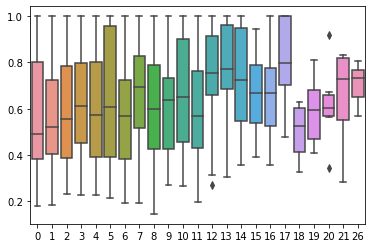

In [10]:
sns.boxplot(x=n_rot_bonds, y=max_sims)

In [11]:
n_rot_bonds = []
max_sims = []
mean_rmses = []
n_generated = []
for smiles, results in mol_results.items() :
    if 'rmse_all' in results :
        n_rot_bonds.append(results['n_rotatable_bonds'])
        max_sims.append(results['max_sim_to_training'])
        mean_rmses.append(results['rmse_all'])
        n_generated.append(results['n_generated'])

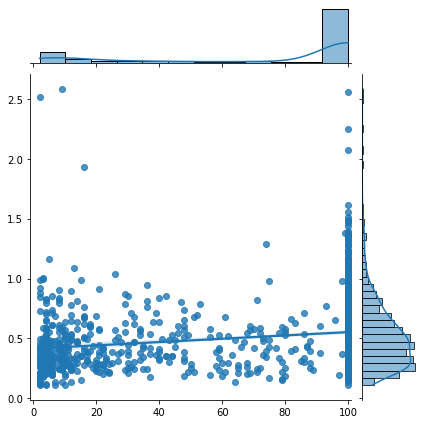

In [12]:
sns.jointplot(x=n_generated, y=mean_rmses, kind='reg', xlim=(-1, 101))

In [13]:
flexible_smiles = []
for smiles, results in mol_results.items() :
    if results['n_rotatable_bonds'] == 26 :
        flexible_smiles.append(smiles)
        print(results['n_generated'])

100
100
100


In [14]:
flexible_smiles

['C[C@@H](O)[C@H](NC(=O)[C@H](CCCC[NH3+])NC(=O)[C@H](CCCNC(N)=[NH2+])NC(=O)[C@H](CCCC[NH3+])NC(=O)[C@@H]([NH3+])CCCNC(N)=[NH2+])C(=O)[O-]',
 'CC(C)[C@H](NC(=O)[C@H](CCCC[NH3+])NC(=O)[C@H](CCCNC(N)=[NH2+])NC(=O)[C@H](CCCC[NH3+])NC(=O)[C@@H]([NH3+])CCCC[NH3+])C(=O)[O-]',
 'COCCOCCOCCOCCOCc1cn(CCCC[C@H](NC(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])C(=O)[O-])nn1']

In [15]:
cel = ConfEnsembleLibrary()
cel.load_metadata()

In [16]:
pmp = PDBBindMetadataProcessor()
table = pmp.get_master_dataframe()

In [17]:
smiles = flexible_smiles[2]
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
test_mol = ce.mol
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
17921,2xej,1.78,2010,8.87,Ki=1.34nM //,2xef.pdf,(OKD),"[nM, =, 1.34]",=,1.34,nM,2010,Q04609,GLUTAMATE CARBOXYPEPTIDASE 2,True


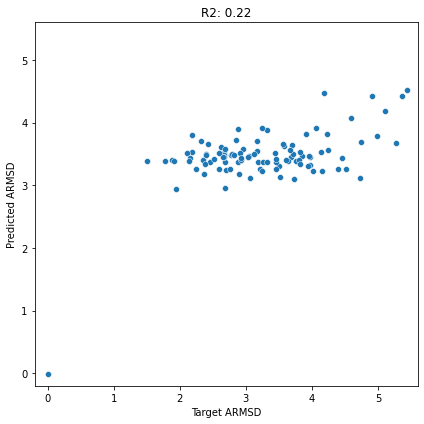

In [58]:
x = conf_results[smiles]['targets']
y = conf_results[smiles]['preds']
r2 = r2_score(x, y)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y)
plt.xlim(-0.2, 5.6)
plt.ylim(-0.2, 5.6)
plt.xlabel('Target ARMSD')
plt.ylabel('Predicted ARMSD')
plt.title(f'R2: {r2:.2f}')
plt.tight_layout()
plt.savefig('large_mol_regression.png', dpi=300)

In [24]:
save_2d_depiction(test_mol, 'test_mol.png')

AlignMolConformers(test_mol, atomIds=list(range(22, 39)))
mcv.view(test_mol)

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning


interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [25]:
sdwriter = Chem.SDWriter('mol.sdf')
for conf in test_mol.GetConformers() :
    sdwriter.write(test_mol, confId=conf.GetId())
sdwriter.close()

In [26]:
train_mol = get_most_similar_mol_in_train(test_mol, train_fps)
pdb_id = train_mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

mcv.view(train_mol)

Tanimoto similarity:  0.5677083333333334


interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [27]:
mcs = rdFMCS.FindMCS([test_mol, train_mol])
core = Chem.MolFromSmarts(mcs.smartsString)

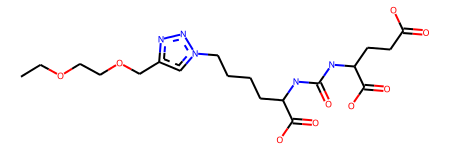

In [28]:
core

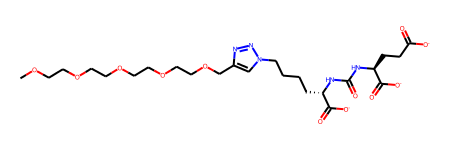

In [29]:
def mol_3d_to_2d(mol) :
    copy_mol = copy.deepcopy(mol)
    copy_mol.RemoveAllConformers()
    return copy_mol
copy_1 = mol_3d_to_2d(ce.mol)
copy_1

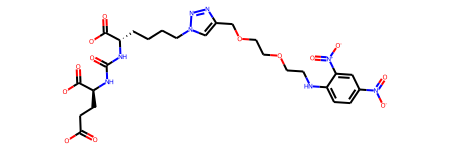

In [30]:
copy_2 = mol_3d_to_2d(train_mol)
copy_2

In [31]:
query_match = copy_1.GetSubstructMatch(core)
template_match = copy_2.GetSubstructMatch(core)
AllChem.Compute2DCoords(copy_1)
AllChem.Compute2DCoords(copy_2)
rms = AlignMol(copy_1, copy_2, atomMap=list(zip(query_match,template_match)))
save_2d_depiction(copy_1, 'mol1.png')
save_2d_depiction(copy_2, 'mol2.png')

In [32]:
model = get_model()
model.eval()
import torch
with torch.no_grad() :
    model.show_atomic_contributions(test_mol, suffix='Test')
    model.show_atomic_contributions(train_mol, suffix='Similar_train')

In [33]:
data_list = mf.featurize_mol(test_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(test_mol.GetNumConformers(), test_mol.GetNumAtoms())

In [34]:
bioactive_mol = copy.deepcopy(test_mol)
bioactive_mol.RemoveAllConformers()
bioactive_mol.AddConformer(test_mol.GetConformer(100), assignId=True)
generated_mol = copy.deepcopy(test_mol)
generated_mol.RemoveConformer(100)

mol_dict = {'Bioactive': bioactive_mol,
            'Generated': generated_mol}

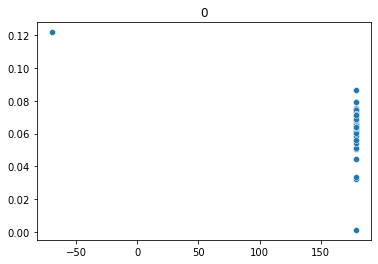

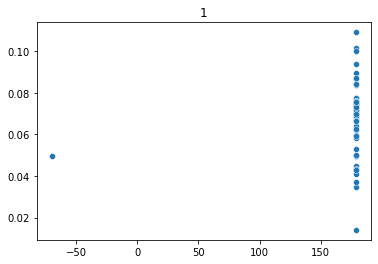

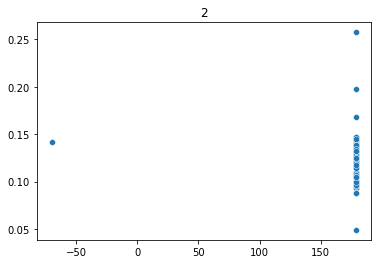

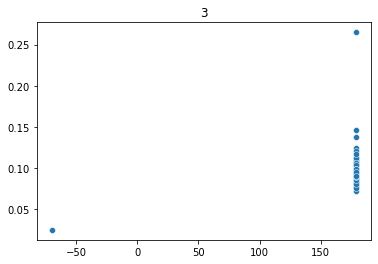

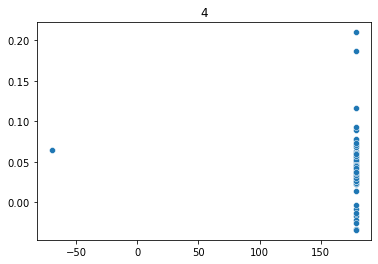

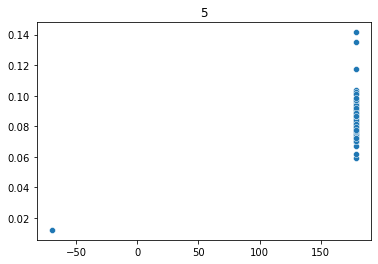

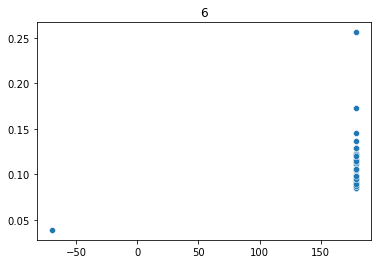

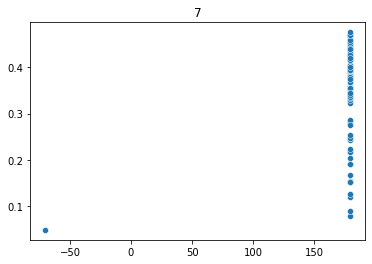

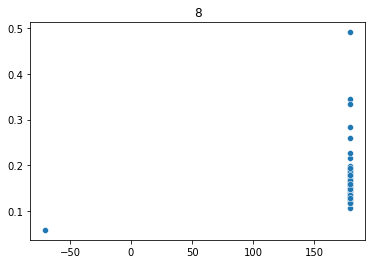

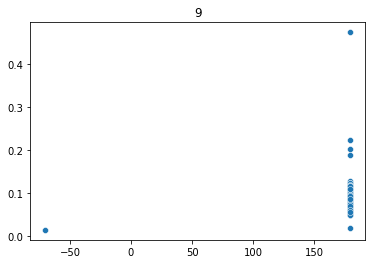

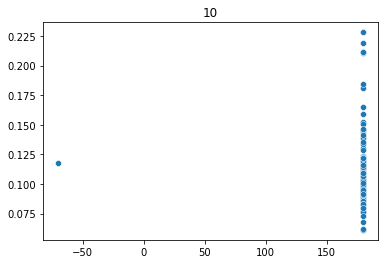

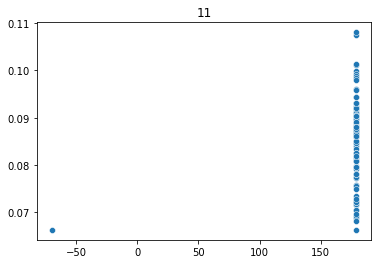

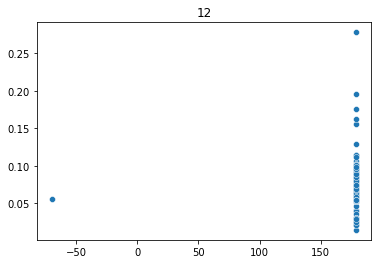

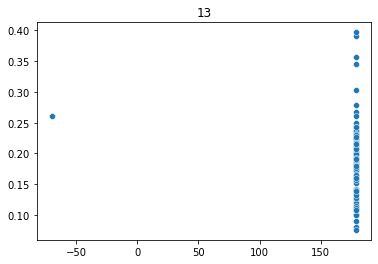

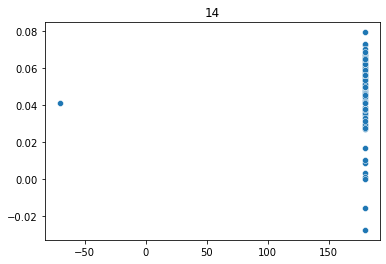

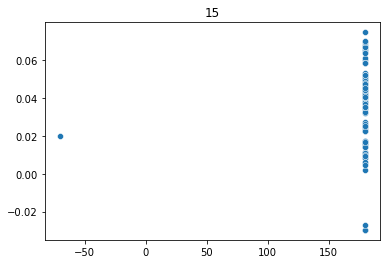

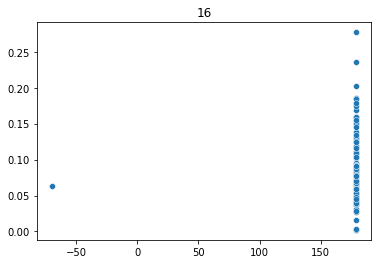

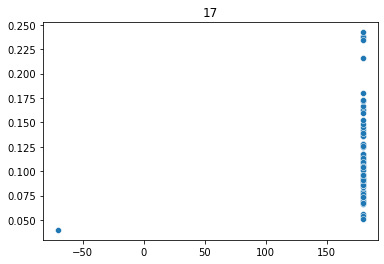

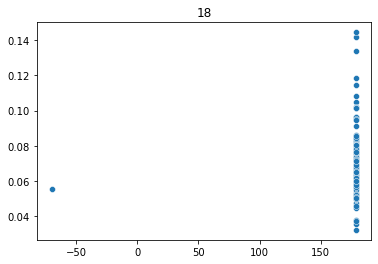

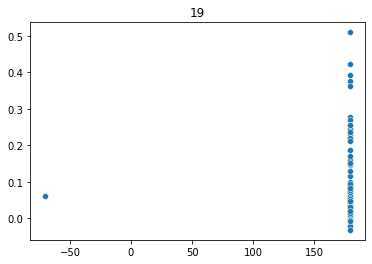

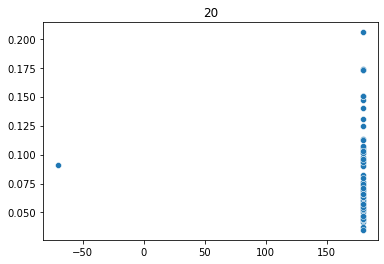

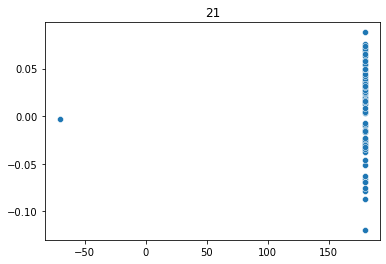

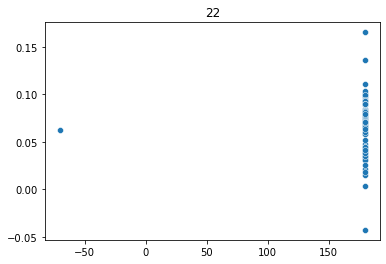

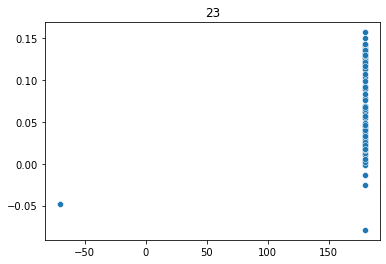

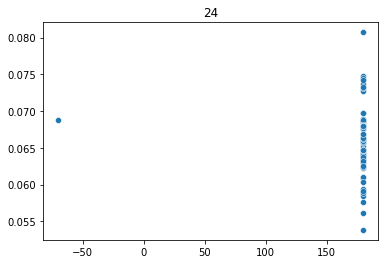

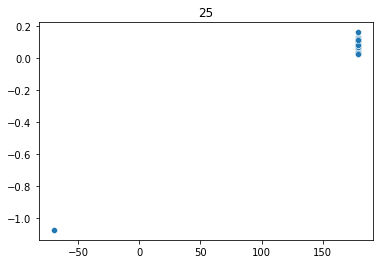

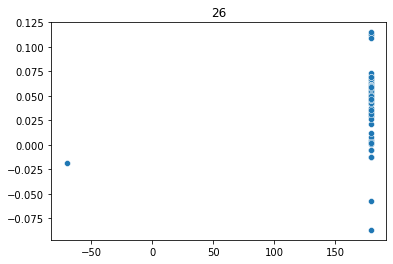

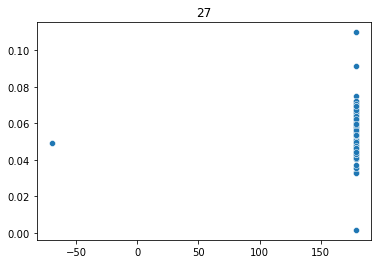

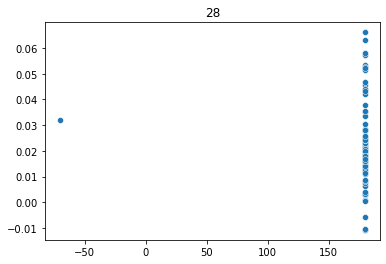

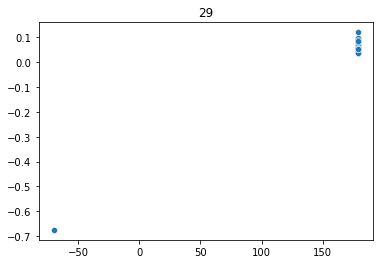

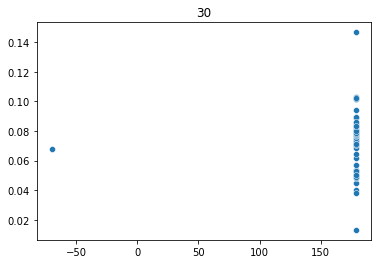

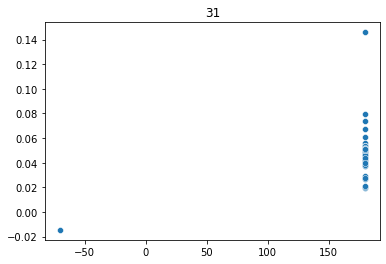

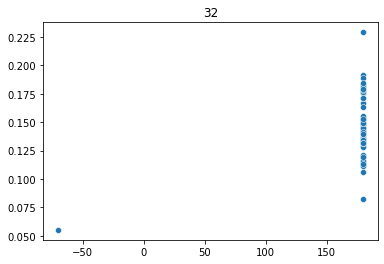

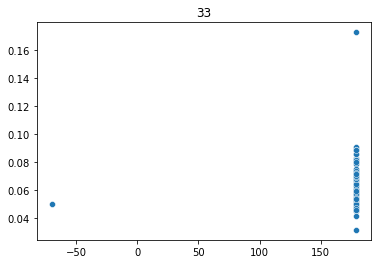

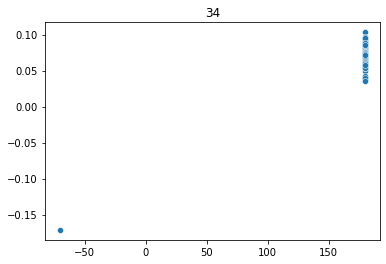

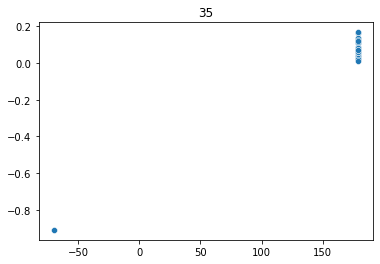

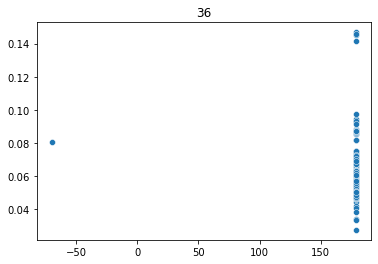

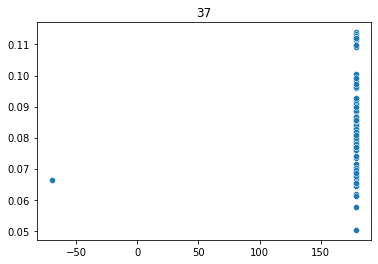

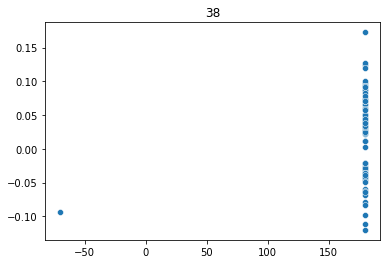

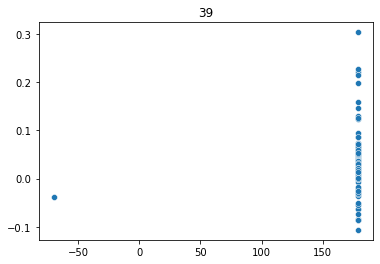

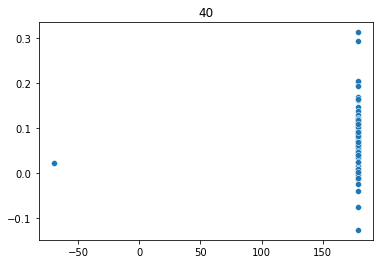

In [35]:
dihedrals = ca.get_conformers_dihedrals_deg(test_mol, 33, 27, 28, 29)
for i in range(grouped_ac.shape[1]) :
    atom_contributions = grouped_ac[:, i]
    sns.scatterplot(x=dihedrals, y=atom_contributions)
    plt.title(i)
    plt.show()

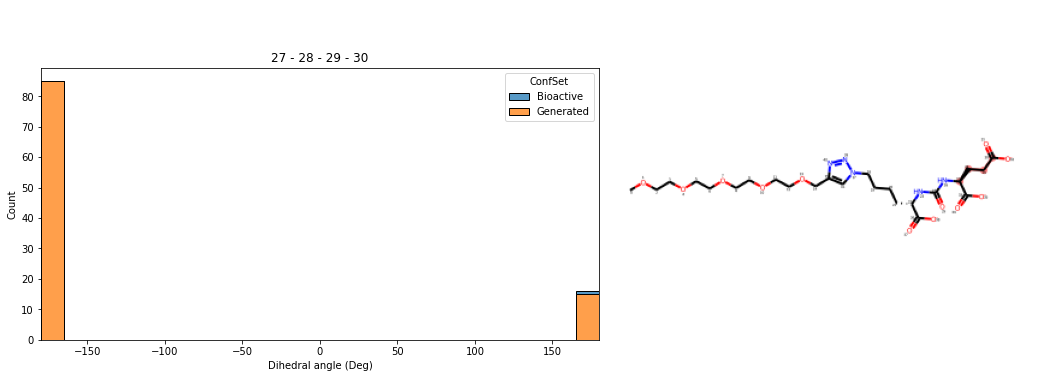

<Figure size 432x288 with 0 Axes>

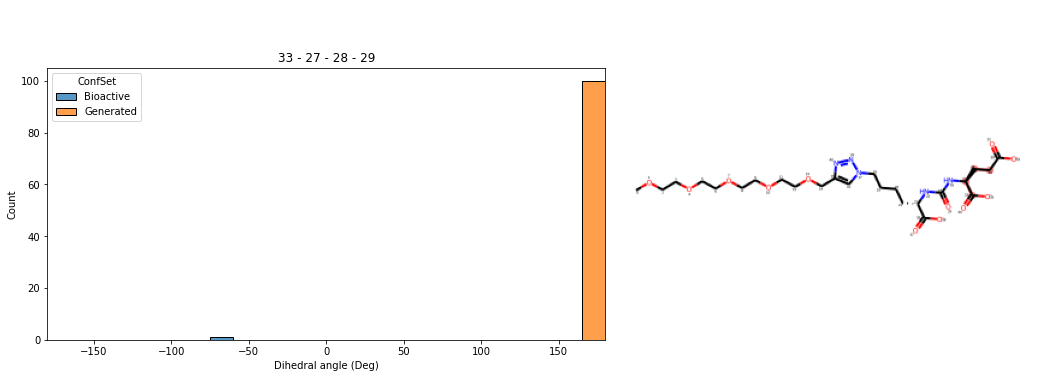

<Figure size 432x288 with 0 Axes>

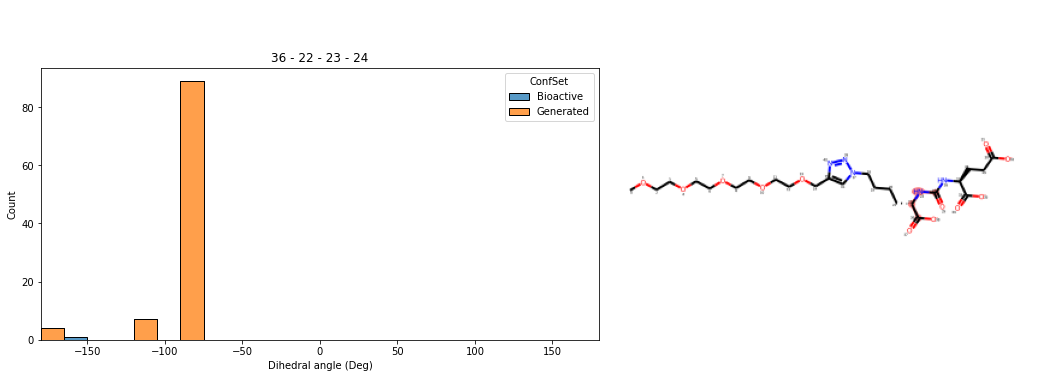

<Figure size 432x288 with 0 Axes>

In [36]:
dihedrals_atom_ids = [(27, 28, 29, 30), (33, 27, 28, 29), (36, 22, 23, 24)]
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, 
                             mol_dict=mol_dict)

In [37]:
data_list = mf.featurize_mol(train_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(train_mol.GetNumConformers(), train_mol.GetNumAtoms())

In [38]:
bioactive_mol = copy.deepcopy(train_mol)
bioactive_mol.RemoveAllConformers()
bioactive_mol.AddConformer(train_mol.GetConformer(100), assignId=True)
generated_mol = copy.deepcopy(train_mol)
generated_mol.RemoveConformer(100)

mol_dict = {'Bioactive': bioactive_mol,
            'Generated': generated_mol}

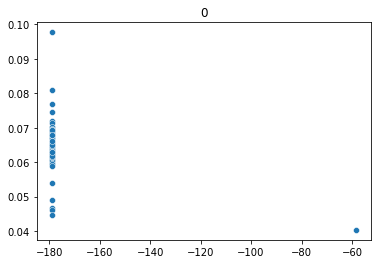

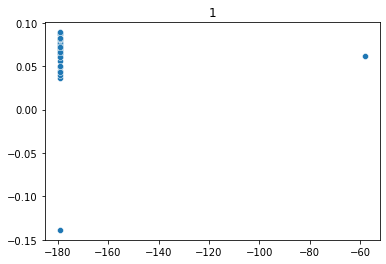

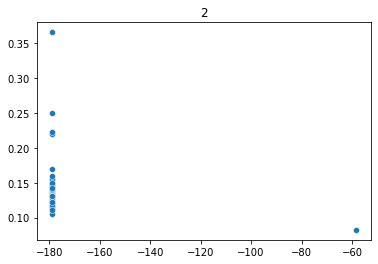

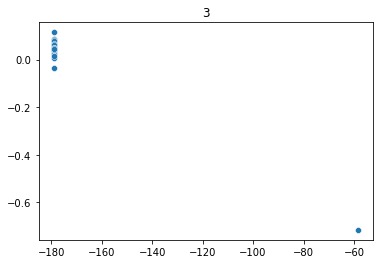

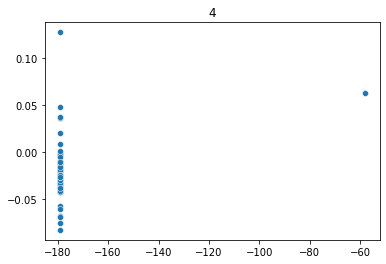

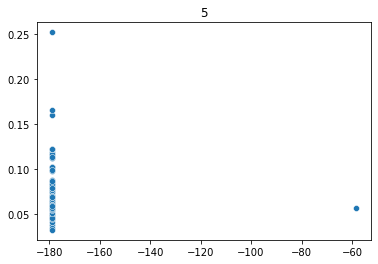

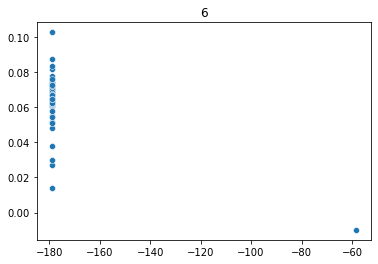

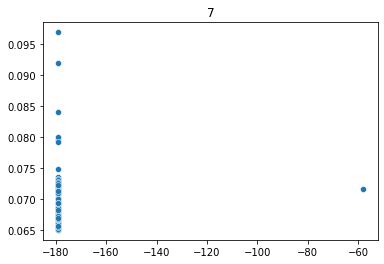

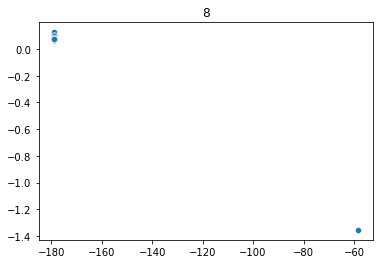

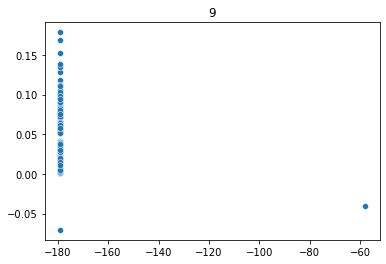

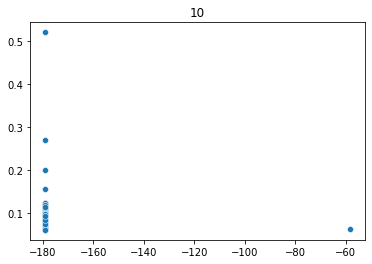

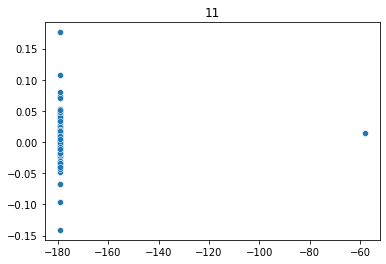

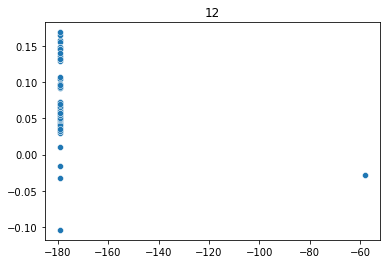

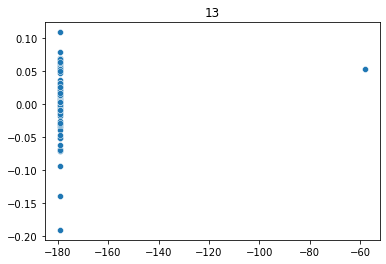

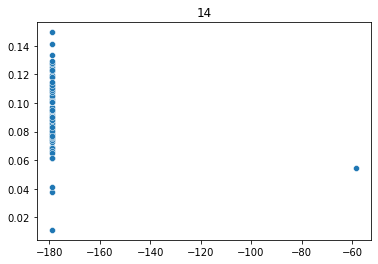

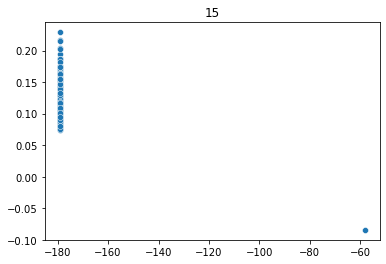

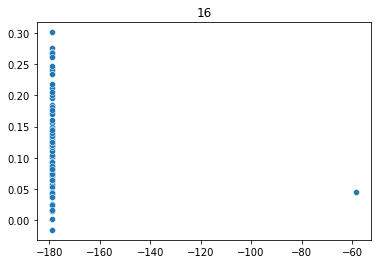

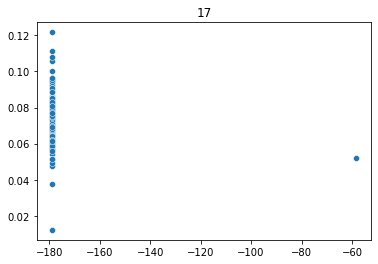

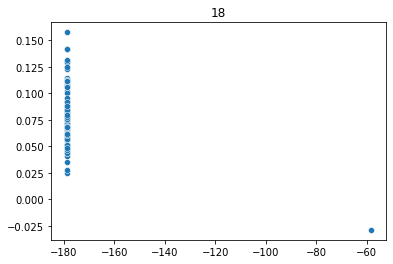

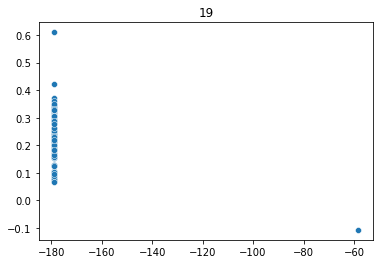

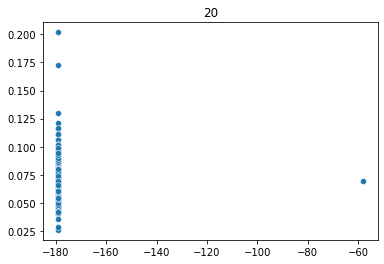

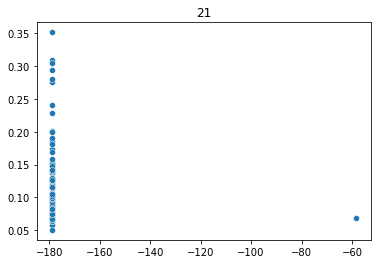

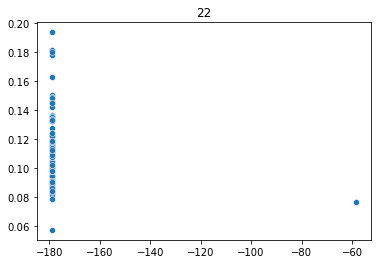

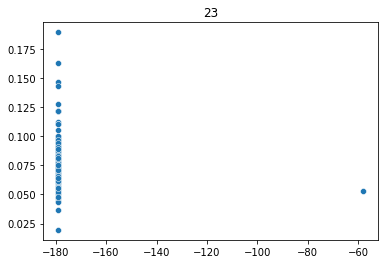

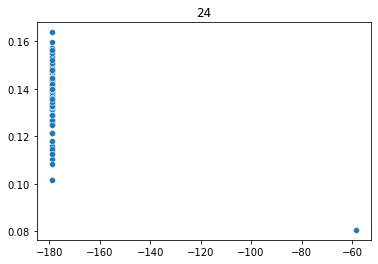

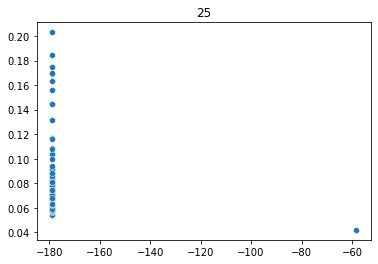

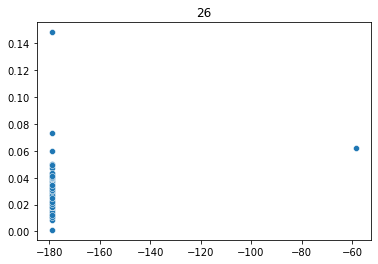

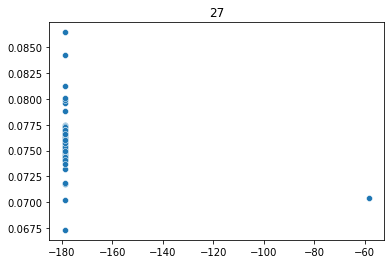

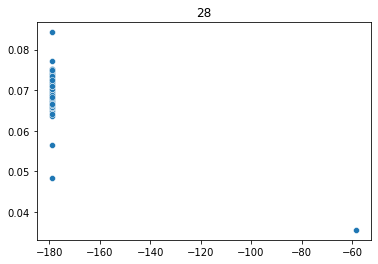

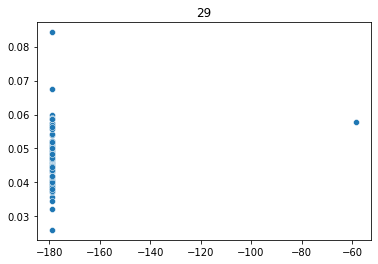

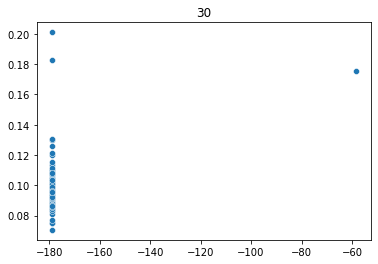

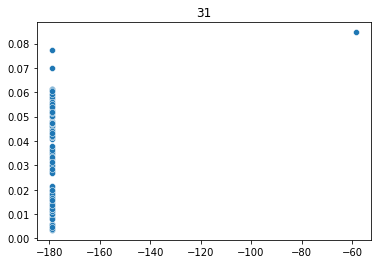

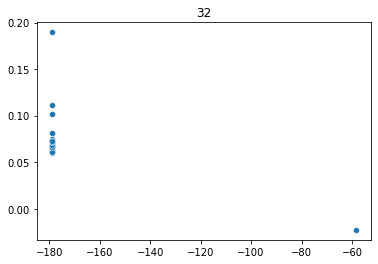

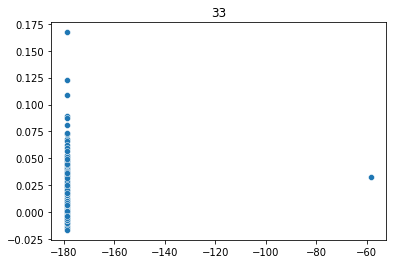

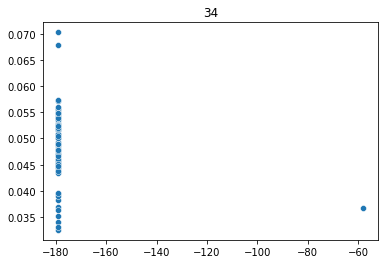

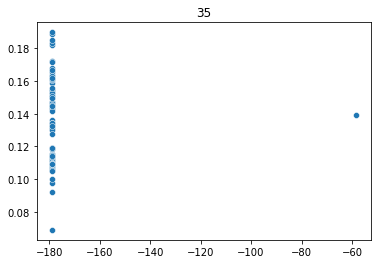

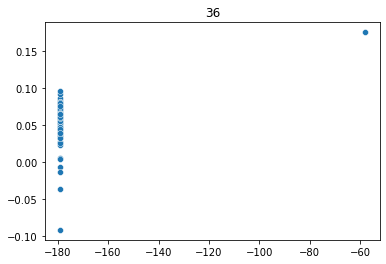

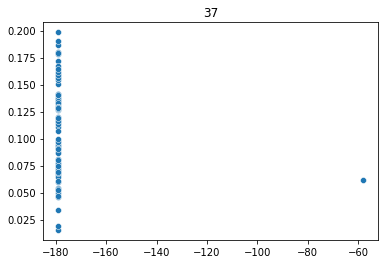

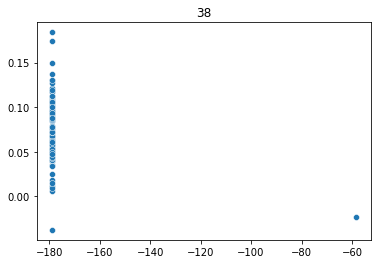

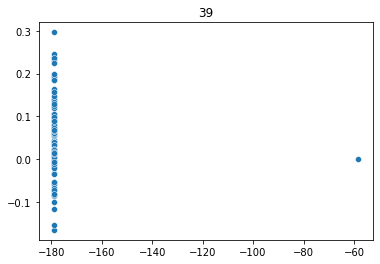

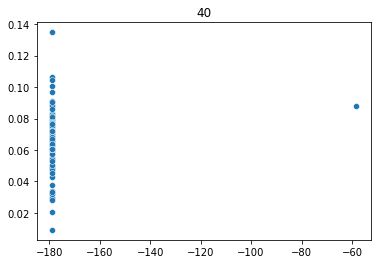

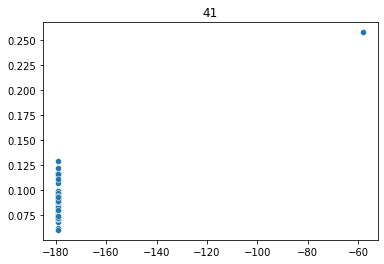

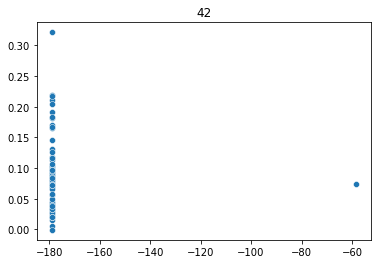

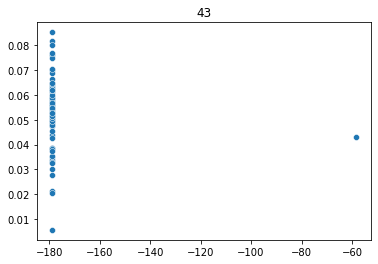

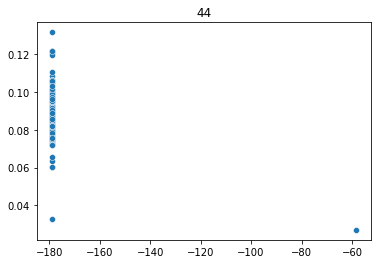

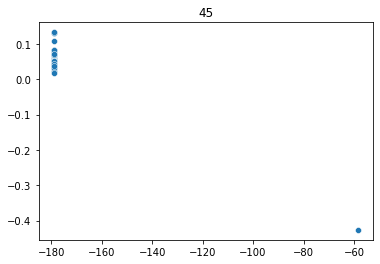

In [39]:
dihedrals = ca.get_conformers_dihedrals_deg(train_mol, 3, 4, 5, 43)
for i in range(grouped_ac.shape[1]) :
    atom_contributions = grouped_ac[:, i]
    sns.scatterplot(x=dihedrals, y=atom_contributions)
    plt.title(i)
    plt.show()

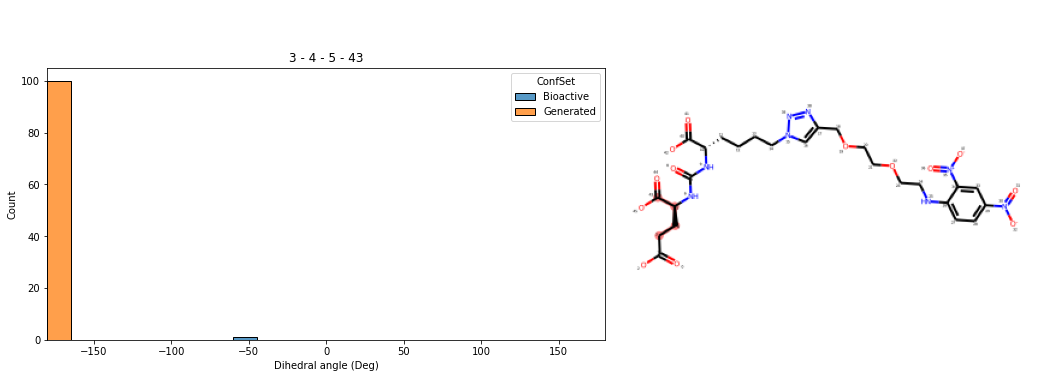

<Figure size 432x288 with 0 Axes>

In [40]:
dihedrals_atom_ids = [(3, 4, 5, 43)]
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, 
                             mol_dict=mol_dict)

In [41]:
targets = mf.get_bioactive_rmsds(train_mol)
preds = model(batch)

In [51]:
from sklearn.metrics import r2_score

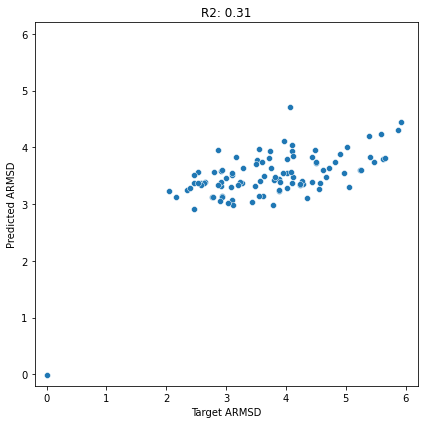

In [56]:
x = targets.detach().numpy()
y = preds.reshape(-1).detach().numpy()
r2 = r2_score(x, y)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y)
plt.xlim(-0.2, 6.2)
plt.ylim(-0.2, 6.2)
plt.xlabel('Target ARMSD')
plt.ylabel('Predicted ARMSD')
plt.title(f'R2: {r2:.2f}')
plt.tight_layout()
plt.savefig('large_mol_regression_train.png', dpi=300)

In [55]:
sdwriter = Chem.SDWriter('test_mol.sdf')
for conf_id in [99, 100] :
    sdwriter.write(test_mol, confId=conf_id)
sdwriter.close()

In [56]:
sdwriter = Chem.SDWriter('train_mol.sdf')
for conf_id in [99, 100] :
    sdwriter.write(test_mol, confId=conf_id)
sdwriter.close()

# Largest regression RMSE

In [37]:
rmses = []
for smiles, results in conf_results.items() :
    rmses.extend(results['rmse'])

In [38]:
max_rmse_idx = np.argmax(rmses)

In [39]:
max_rmse = rmses[max_rmse_idx]
max_rmse

4.579769134521484

In [40]:
for smiles, results in conf_results.items() :
    if max_rmse in results['rmse'] :
        print(smiles)
        break

CC(C)NC(=O)COCCOCCNC(=O)[C@H](C)NC(=O)[C@@H](O)[C@H]([NH3+])Cc1ccc(OCc2ccccc2)cc1


In [41]:
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
10373,3t8v,1.80,2011,6.59,Ki=260nM //,3t8v.pdf,(BTJ),"[nM, =, 260]",=,260.0,nM,2011,O96935,M1 FAMILY AMINOPEPTIDASE,True


(-0.2, 3.790420323610306)

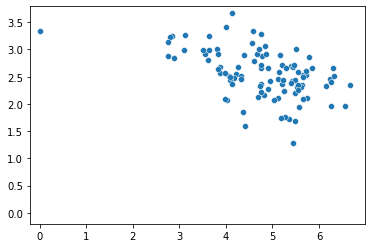

In [42]:
sns.scatterplot(x=results['targets'], y=results['preds'])
plt.xlim(-0.2)
plt.ylim(-0.2)

In [43]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
conf_id_slider = mcv.view(ce.mol,
                         properties=properties)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

In [44]:
mean_rmses = []
for smiles, results in conf_results.items() :
    mol_res = mol_results[smiles]
    if 'rmse_all' in mol_res :
        mean_rmse = mol_res['rmse_all']
        mean_rmses.append(mean_rmse)

In [45]:
max_rmse_idx = np.argmax(mean_rmses)

In [46]:
max_rmse = mean_rmses[max_rmse_idx]

In [47]:
for smiles, results in conf_results.items() :
    mol_res = mol_results[smiles]
    if 'rmse_all' in mol_res :
        mean_rmse = mol_res['rmse_all']
        if max_rmse == mean_rmse :
            print(smiles)
            break

CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4


In [48]:
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
14075,4nct,2.60,2015,7.55,Ki=28.4nM //,4nct.pdf,(2K2),"[nM, =, 28.4]",=,28.4,nM,2015,Q13627,DUAL SPECIFICITY TYROSINE-PHOSPHORYLATION-REGU...,True


(-0.2, 5.857322925329209)

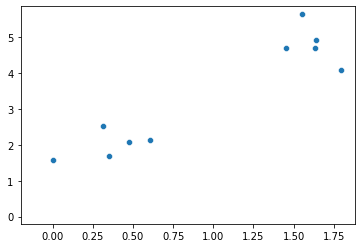

In [49]:
sns.scatterplot(x=results['targets'], y=results['preds'])
plt.xlim(-0.2)
plt.ylim(-0.2)

In [50]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
conf_id_slider = mcv.view(ce.mol,
                         properties=properties)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:', max=9), Output()), _dom_classes=('w…

In [51]:
test_fp = AllChem.GetMorganFingerprint(ce.mol, 3, useChirality=True)
sims = []
for train_fp in train_fps :
    dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
    sims.append(dice_sim)
max_sim = max(sims)
max_sim_idx = np.argmax(sims)
sim_smiles = train_smiles[max_sim_idx]

sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
pdb_id = sim_ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

mf = MoleculeFeaturizer()
model = get_model()
model.eval()
data_list = mf.featurize_mol(sim_ce.mol)
targets = mf.get_bioactive_rmsds(sim_ce.mol).numpy()

batch = Batch.from_data_list(data_list)
preds = model(batch).detach().numpy().squeeze()
errors = np.abs(targets - preds)

properties = {'RMSE' : errors,
              'ARMSD' : targets,
              'Predicted ARMSD' : preds,
              'UFF Energy' : batch.energy.numpy()}
mcv.view(sim_ce.mol,
         properties=properties)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:', max=18), Output()), _dom_classes=('…

BoundedIntText(value=0, description='Conformer ID:', max=18)

In [52]:
new_mol = copy.deepcopy(sim_ce.mol)

In [53]:
d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(new_mol)
d2d.FinishDrawing()
d2d.WriteDrawingText('mol.png') 

In [54]:
AlignMolConformers(new_mol, atomIds=list(range(2, 34)))

In [55]:
mcv.view(new_mol,
         properties=properties)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:', max=18), Output()), _dom_classes=('…

BoundedIntText(value=0, description='Conformer ID:', max=18)

In [56]:
batch

DataBatch(x=[665, 1], edge_index=[2, 1596], pos=[665, 3], data_id=[19], energy=[19], n_heavy_atoms=[19], n_rotatable_bonds=[19], batch=[665], ptr=[20])

In [57]:
mcs = rdFMCS.FindMCS([ce.mol, sim_ce.mol])

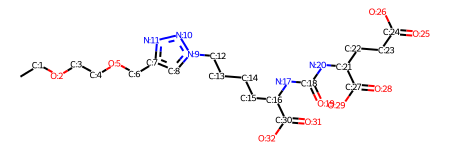

In [58]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(core)

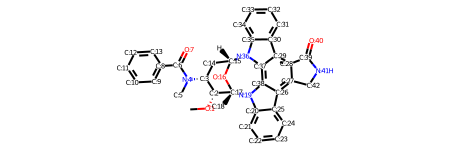

In [59]:
mol_copy = copy.deepcopy(ce.mol)
mol_copy.RemoveAllConformers()
mol_with_atom_index(mol_copy)

In [60]:
core = Chem.MolFromSmarts(mcs.smarts)
mol1_atoms = ce.mol.GetSubstructMatches(core)[0]
mol2_atoms = sim_ce.mol.GetSubstructMatches(core)[0]
atom_map = list(zip(mol1_atoms, mol2_atoms))

AttributeError: 'MCSResult' object has no attribute 'smarts'

In [ ]:
for i in range(ce.mol.GetNumConformers()) :
    AlignMol(ce.mol, sim_ce.mol, i, 3, atomMap=atom_map)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
mcv.view(ce.mol, properties)
mcv.view(sim_ce.mol)